In [7]:
"""
===============================================================================
DRUG RELEASE PROFILE VISUALIZATION - JUPYTER NOTEBOOK VERSION
===============================================================================
Author: [Student Name]
Project: Pharmaceutical Research - Lamar University ChemE Dept
Date: August 2023

Dr. Martinez asked if I could make something where people can 
input their data and see the results instantly without coding.

Original version used tkinter but that doesn't work in Jupyter...
So I learned about ipywidgets instead!

This version works in Jupyter Notebook/Lab and Google Colab

To use:
1. Run all cells
2. Use the dropdown to select a model
3. Click buttons to fit and visualize
4. Modify the data arrays to use your own data

Now used by 3 lab groups in the department!
===============================================================================
"""

# First, install ipywidgets if needed (uncomment if necessary)
# !pip install ipywidgets

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# For Jupyter interactivity
%matplotlib inline
# Use this for interactive plots: %matplotlib widget

# ============================================================================
# KINETIC MODELS
# ============================================================================

def zero_order(t, k):
    """Zero-order: constant release rate"""
    return k * t

def first_order(t, k):
    """First-order: rate depends on remaining drug"""
    return 100 * (1 - np.exp(-k * t))

def higuchi(t, k):
    """Higuchi: diffusion from planar matrix"""
    return k * np.sqrt(t)

def korsmeyer_peppas(t, k, n):
    """Korsmeyer-Peppas: power law model"""
    return k * (t ** n)

def hixson_crowell(t, k, Q0=100):
    """Hixson-Crowell: changing surface area"""
    term = 1 - k * t / (Q0 ** (1/3))
    term = np.maximum(term, 0)
    return Q0 * (1 - term ** 3)

MODELS = {
    'Zero Order': {'func': zero_order, 'p0': [2], 'params': ['k']},
    'First Order': {'func': first_order, 'p0': [0.1], 'params': ['k']},
    'Higuchi': {'func': higuchi, 'p0': [15], 'params': ['k']},
    'Korsmeyer-Peppas': {'func': korsmeyer_peppas, 'p0': [20, 0.5], 'params': ['k', 'n']},
    'Hixson-Crowell': {'func': hixson_crowell, 'p0': [1], 'params': ['k']}
}

# ============================================================================
# SAMPLE DATA - MODIFY THIS WITH YOUR OWN DATA!
# ============================================================================

# Default experimental data (replace with your own)
TIME_DATA = np.array([0.5, 1, 2, 4, 6, 8, 12, 24, 48])  # hours
RELEASE_DATA = np.array([12, 18, 28, 45, 58, 67, 78, 89, 95])  # percent

# ============================================================================
# ANALYSIS FUNCTIONS
# ============================================================================

def calc_r_squared(observed, predicted):
    """Calculate R² value"""
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    if ss_tot == 0:
        return 0
    return 1 - (ss_res / ss_tot)

def calc_rmse(observed, predicted):
    """Calculate RMSE"""
    return np.sqrt(np.mean((observed - predicted) ** 2))

def fit_single_model(time, release, model_name):
    """Fit a single model and return results"""
    model_info = MODELS[model_name]
    
    try:
        popt, pcov = curve_fit(model_info['func'], time, release, 
                               p0=model_info['p0'], maxfev=10000)
        predicted = model_info['func'](time, *popt)
        r2 = calc_r_squared(release, predicted)
        rmse = calc_rmse(release, predicted)
        
        return {
            'success': True,
            'params': dict(zip(model_info['params'], popt)),
            'popt': popt,
            'r2': r2,
            'rmse': rmse,
            'predicted': predicted
        }
    except Exception as e:
        return {'success': False, 'error': str(e)}

def fit_all_models(time, release):
    """Fit all models and return comparison"""
    results = {}
    for name in MODELS.keys():
        results[name] = fit_single_model(time, release, name)
    return results


# ============================================================================
# VISUALIZATION FUNCTIONS - The main stuff!
# ============================================================================

def plot_single_model(time, release, model_name, figsize=(10, 6)):
    """
    Plot experimental data with a single fitted model
    
    My first version just did plt.plot()... this is much better!
    
    Parameters:
    -----------
    time : array - time points (hours)
    release : array - release percentages
    model_name : str - name of model to fit
    """
    # Fit the model
    result = fit_single_model(time, release, model_name)
    
    if not result['success']:
        print(f"Error fitting {model_name}: {result['error']}")
        return
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot experimental data
    ax.plot(time, release, 'ko', markersize=10, label='Experimental Data', zorder=5)
    
    # Plot fitted curve (smooth)
    t_smooth = np.linspace(min(time) * 0.5, max(time) * 1.1, 200)
    model_func = MODELS[model_name]['func']
    y_smooth = model_func(t_smooth, *result['popt'])
    y_smooth = np.clip(y_smooth, 0, 105)  # keep reasonable range
    
    ax.plot(t_smooth, y_smooth, 'r-', linewidth=2.5, 
            label=f"{model_name} Fit (R² = {result['r2']:.4f})")
    
    # Formatting
    ax.set_xlabel('Time (hours)', fontsize=12)
    ax.set_ylabel('Drug Release (%)', fontsize=12)
    ax.set_title(f'Drug Release Kinetics - {model_name} Model', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, max(time) * 1.15)
    ax.set_ylim(0, 105)
    
    plt.tight_layout()
    plt.show()
    
    # Print results
    print("="*50)
    print(f"MODEL: {model_name}")
    print("="*50)
    print("\nFitted Parameters:")
    for name, value in result['params'].items():
        print(f"  {name} = {value:.4f}")
    print(f"\nGoodness of Fit:")
    print(f"  R² = {result['r2']:.4f}")
    print(f"  RMSE = {result['rmse']:.2f}%")
    
    # Interpretation for Korsmeyer-Peppas
    if model_name == 'Korsmeyer-Peppas':
        n = result['params']['n']
        print(f"\nRelease Mechanism Interpretation:")
        if n < 0.45:
            print(f"  n = {n:.3f} → Fickian diffusion (Case I)")
        elif n < 0.89:
            print(f"  n = {n:.3f} → Anomalous transport (non-Fickian)")
        else:
            print(f"  n = {n:.3f} → Case II transport (relaxation-controlled)")
    
    return result


def plot_all_models(time, release, figsize=(14, 8)):
    """
    Plot all models on one graph for comparison
    
    This is what people use most - see all fits at once!
    
    Parameters:
    -----------
    time : array - time points
    release : array - release percentages
    """
    # Fit all models
    results = fit_all_models(time, release)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot experimental data
    ax.plot(time, release, 'ko', markersize=12, label='Experimental', zorder=5)
    
    # Plot each model
    t_smooth = np.linspace(min(time) * 0.5, max(time) * 1.1, 200)
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12']
    
    for (model_name, result), color in zip(results.items(), colors):
        if result['success']:
            model_func = MODELS[model_name]['func']
            y_smooth = model_func(t_smooth, *result['popt'])
            y_smooth = np.clip(y_smooth, 0, 110)
            ax.plot(t_smooth, y_smooth, '-', color=color, linewidth=2, alpha=0.8,
                   label=f"{model_name} (R²={result['r2']:.3f})")
    
    ax.set_xlabel('Time (hours)', fontsize=12)
    ax.set_ylabel('Drug Release (%)', fontsize=12)
    ax.set_title('Comparison of All Kinetic Models', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, max(time) * 1.15)
    ax.set_ylim(0, 105)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n" + "="*60)
    print("MODEL COMPARISON SUMMARY")
    print("="*60)
    print(f"{'Model':<22} {'R²':<10} {'RMSE':<10} {'Best?':<6}")
    print("-"*60)
    
    # Find best model
    best_r2 = max([r['r2'] for r in results.values() if r['success']])
    
    for model_name, result in results.items():
        if result['success']:
            is_best = "  ✓" if result['r2'] == best_r2 else ""
            print(f"{model_name:<22} {result['r2']:<10.4f} {result['rmse']:<10.2f} {is_best}")
        else:
            print(f"{model_name:<22} FAILED")
    
    print("="*60)
    
    return results


def interactive_analysis(time, release):
    """
    Fully interactive analysis with all plots and statistics
    
    This function does everything - just pass your data!
    
    Parameters:
    -----------
    time : array or list - time points in hours
    release : array or list - release percentages (0-100)
    
    Example:
    --------
    time = [0.5, 1, 2, 4, 6, 8, 12, 24, 48]
    release = [12, 18, 28, 45, 58, 67, 78, 89, 95]
    interactive_analysis(time, release)
    """
    time = np.array(time)
    release = np.array(release)
    
    # Remove t=0 if present (causes issues with some models)
    mask = time > 0
    time = time[mask]
    release = release[mask]
    
    print("="*60)
    print("DRUG RELEASE KINETICS ANALYZER")
    print("="*60)
    print(f"\nData points: {len(time)}")
    print(f"Time range: {time.min():.1f} - {time.max():.1f} hours")
    print(f"Release range: {release.min():.1f} - {release.max():.1f}%")
    
    # Fit and plot all models
    results = plot_all_models(time, release)
    
    # Find and display best model details
    best_model = max(results.items(), key=lambda x: x[1]['r2'] if x[1]['success'] else -1)
    
    print(f"\n{'='*60}")
    print(f"BEST MODEL: {best_model[0]}")
    print(f"{'='*60}")
    
    # Plot just the best model
    plot_single_model(time, release, best_model[0])
    
    return results


# ============================================================================
# QUICK PLOT FUNCTIONS - For fast analysis
# ============================================================================

def quick_higuchi(time, release):
    """Quick Higuchi model analysis"""
    plot_single_model(np.array(time), np.array(release), 'Higuchi')

def quick_korsmeyer(time, release):
    """Quick Korsmeyer-Peppas analysis"""
    plot_single_model(np.array(time), np.array(release), 'Korsmeyer-Peppas')

def quick_first_order(time, release):
    """Quick First Order analysis"""
    plot_single_model(np.array(time), np.array(release), 'First Order')


# ============================================================================
# DEMO / EXAMPLE USAGE
# ============================================================================

print("="*60)
print("DRUG RELEASE KINETICS ANALYZER - JUPYTER VERSION")
print("="*60)
print("""
This tool is now used by 3 lab groups in the department!
- Dr. Martinez's group (pharmaceutics)
- Dr. Chen's group (polymer science)  
- Dr. Thompson's group (drug delivery)

HOW TO USE:
-----------
1. Quick analysis with default data:
   >>> plot_all_models(TIME_DATA, RELEASE_DATA)
   
2. Fit a specific model:
   >>> plot_single_model(TIME_DATA, RELEASE_DATA, 'Korsmeyer-Peppas')
   
3. Full interactive analysis:
   >>> interactive_analysis(TIME_DATA, RELEASE_DATA)

4. Use YOUR OWN DATA:
   >>> my_time = [0.5, 1, 2, 4, 8, 12, 24]
   >>> my_release = [5, 12, 22, 40, 65, 78, 95]
   >>> interactive_analysis(my_time, my_release)

Available models:
- 'Zero Order'
- 'First Order'  
- 'Higuchi'
- 'Korsmeyer-Peppas'
- 'Hixson-Crowell'
""")
print("="*60)

# ============================================================================
# RUN DEMO WITH SAMPLE DATA
# ============================================================================




DRUG RELEASE KINETICS ANALYZER - JUPYTER VERSION

This tool is now used by 3 lab groups in the department!
- Dr. Martinez's group (pharmaceutics)
- Dr. Chen's group (polymer science)  
- Dr. Thompson's group (drug delivery)

HOW TO USE:
-----------
1. Quick analysis with default data:
   >>> plot_all_models(TIME_DATA, RELEASE_DATA)

2. Fit a specific model:
   >>> plot_single_model(TIME_DATA, RELEASE_DATA, 'Korsmeyer-Peppas')

3. Full interactive analysis:
   >>> interactive_analysis(TIME_DATA, RELEASE_DATA)

4. Use YOUR OWN DATA:
   >>> my_time = [0.5, 1, 2, 4, 8, 12, 24]
   >>> my_release = [5, 12, 22, 40, 65, 78, 95]
   >>> interactive_analysis(my_time, my_release)

Available models:
- 'Zero Order'
- 'First Order'  
- 'Higuchi'
- 'Korsmeyer-Peppas'
- 'Hixson-Crowell'



In [17]:
"""
===============================================================================
DRUG RELEASE PROFILE - INTERACTIVE JUPYTER GUI WITH WIDGETS
===============================================================================
Author: [Christopher Ezike]
Project: Pharmaceutical Research - Lamar University ChemE Dept
Date: August 2023

This version uses ipywidgets for a real interactive GUI in Jupyter!
Has dropdown menus, buttons, and sliders - just like a desktop app

Install first if needed:
    !pip install ipywidgets
    
For JupyterLab, also run:
    !jupyter labextension install @jupyter-widgets/jupyterlab-manager

Now used by 3 lab groups in the department!
===============================================================================
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# Try to import ipywidgets - if not available, use basic version
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    WIDGETS_AVAILABLE = True
    print("✓ ipywidgets loaded successfully!")
except ImportError:
    WIDGETS_AVAILABLE = False
    print("⚠ ipywidgets not available. Install with: !pip install ipywidgets")
    print("  Using basic plotting functions instead.")

# ============================================================================
# KINETIC MODELS (same as before)
# ============================================================================

def zero_order(t, k):
    return k * t

def first_order(t, k):
    return 100 * (1 - np.exp(-k * t))

def higuchi(t, k):
    return k * np.sqrt(t)

def korsmeyer_peppas(t, k, n):
    return k * (t ** n)

def hixson_crowell(t, k, Q0=100):
    term = 1 - k * t / (Q0 ** (1/3))
    term = np.maximum(term, 0)
    return Q0 * (1 - term ** 3)

MODELS = {
    'Zero Order': {'func': zero_order, 'p0': [2], 'params': ['k']},
    'First Order': {'func': first_order, 'p0': [0.1], 'params': ['k']},
    'Higuchi': {'func': higuchi, 'p0': [15], 'params': ['k']},
    'Korsmeyer-Peppas': {'func': korsmeyer_peppas, 'p0': [20, 0.5], 'params': ['k', 'n']},
    'Hixson-Crowell': {'func': hixson_crowell, 'p0': [1], 'params': ['k']}
}

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def calc_r_squared(observed, predicted):
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (ss_res / ss_tot) if ss_tot != 0 else 0

def calc_rmse(observed, predicted):
    return np.sqrt(np.mean((observed - predicted) ** 2))

def fit_model(time, release, model_name):
    """Fit a model and return results"""
    model_info = MODELS[model_name]
    try:
        popt, _ = curve_fit(model_info['func'], time, release, 
                           p0=model_info['p0'], maxfev=10000)
        predicted = model_info['func'](time, *popt)
        return {
            'success': True,
            'popt': popt,
            'params': dict(zip(model_info['params'], popt)),
            'r2': calc_r_squared(release, predicted),
            'rmse': calc_rmse(release, predicted)
        }
    except:
        return {'success': False}

# ============================================================================
# INTERACTIVE GUI CLASS (uses ipywidgets)
# ============================================================================

class DrugReleaseAnalyzerGUI:
    """
    Interactive GUI for Drug Release Analysis in Jupyter
    
    My journey making this:
    - First tried tkinter... doesn't work in Jupyter
    - Then found ipywidgets - this is perfect!
    - Took me a while to figure out the Output widget for plots
    
    Usage:
        gui = DrugReleaseAnalyzerGUI()
        gui.display()
    """
    
    def __init__(self):
        # Default data
        self.time_data = np.array([0.5, 1, 2, 4, 6, 8, 12, 24, 48])
        self.release_data = np.array([12, 18, 28, 45, 58, 67, 78, 89, 95])
        
        # Create widgets
        self._create_widgets()
        
    def _create_widgets(self):
        """Create all the GUI widgets"""
        
        # === DATA INPUT ===
        self.time_input = widgets.Textarea(
            value='0.5, 1, 2, 4, 6, 8, 12, 24, 48',
            placeholder='Enter time points (comma-separated)',
            description='Time (hr):',
            layout=widgets.Layout(width='400px', height='60px')
        )
        
        self.release_input = widgets.Textarea(
            value='12, 18, 28, 45, 58, 67, 78, 89, 95',
            placeholder='Enter release % (comma-separated)',
            description='Release (%):',
            layout=widgets.Layout(width='400px', height='60px')
        )
        
        # === MODEL SELECTION ===
        self.model_dropdown = widgets.Dropdown(
            options=list(MODELS.keys()),
            value='Korsmeyer-Peppas',
            description='Model:',
            layout=widgets.Layout(width='300px')
        )
        
        # === BUTTONS ===
        self.fit_button = widgets.Button(
            description='Fit Selected Model',
            button_style='primary',
            icon='chart-line',
            layout=widgets.Layout(width='180px')
        )
        self.fit_button.on_click(self._on_fit_clicked)
        
        self.compare_button = widgets.Button(
            description='Compare All Models',
            button_style='success',
            icon='balance-scale',
            layout=widgets.Layout(width='180px')
        )
        self.compare_button.on_click(self._on_compare_clicked)
        
        self.sample_button = widgets.Button(
            description='Load Sample Data',
            button_style='info',
            icon='database',
            layout=widgets.Layout(width='180px')
        )
        self.sample_button.on_click(self._on_sample_clicked)
        
        # === OUTPUT AREAS ===
        self.plot_output = widgets.Output(
            layout=widgets.Layout(width='100%', min_height='400px')
        )
        
        self.results_output = widgets.Output(
            layout=widgets.Layout(width='100%', border='1px solid #ddd', padding='10px')
        )
        
    def _parse_input(self):
        """Parse text input into arrays"""
        try:
            time_str = self.time_input.value.replace('\n', ',')
            release_str = self.release_input.value.replace('\n', ',')
            
            time = np.array([float(x.strip()) for x in time_str.split(',') if x.strip()])
            release = np.array([float(x.strip()) for x in release_str.split(',') if x.strip()])
            
            # Remove zero time
            mask = time > 0
            time = time[mask]
            release = release[mask]
            
            if len(time) != len(release):
                raise ValueError("Time and release arrays must have same length!")
            
            self.time_data = time
            self.release_data = release
            return True
            
        except Exception as e:
            with self.results_output:
                clear_output()
                print(f"❌ Input Error: {e}")
            return False
    
    def _on_fit_clicked(self, b):
        """Handle fit button click"""
        if not self._parse_input():
            return
            
        model_name = self.model_dropdown.value
        result = fit_model(self.time_data, self.release_data, model_name)
        
        # Update plot
        with self.plot_output:
            clear_output(wait=True)
            
            fig, ax = plt.subplots(figsize=(10, 6))
            
            # Experimental data
            ax.plot(self.time_data, self.release_data, 'ko', markersize=10, 
                   label='Experimental', zorder=5)
            
            if result['success']:
                # Fitted curve
                t_smooth = np.linspace(0.1, max(self.time_data)*1.1, 200)
                y_smooth = MODELS[model_name]['func'](t_smooth, *result['popt'])
                y_smooth = np.clip(y_smooth, 0, 105)
                
                ax.plot(t_smooth, y_smooth, 'r-', linewidth=2.5,
                       label=f"{model_name} (R² = {result['r2']:.4f})")
            
            ax.set_xlabel('Time (hours)', fontsize=12)
            ax.set_ylabel('Drug Release (%)', fontsize=12)
            ax.set_title(f'Drug Release Kinetics - {model_name}', fontsize=14, fontweight='bold')
            ax.legend(loc='lower right', fontsize=11)
            ax.grid(True, alpha=0.3)
            ax.set_xlim(0, max(self.time_data)*1.15)
            ax.set_ylim(0, 105)
            
            plt.tight_layout()
            plt.show()
        
        # Update results
        with self.results_output:
            clear_output()
            if result['success']:
                print(f"{'='*50}")
                print(f"MODEL: {model_name}")
                print(f"{'='*50}")
                print(f"\nFitted Parameters:")
                for name, val in result['params'].items():
                    print(f"  {name} = {val:.4f}")
                print(f"\nGoodness of Fit:")
                print(f"  R² = {result['r2']:.4f}")
                print(f"  RMSE = {result['rmse']:.2f}%")
                
                if model_name == 'Korsmeyer-Peppas':
                    n = result['params']['n']
                    print(f"\nRelease Mechanism:")
                    if n < 0.45:
                        print(f"  n = {n:.3f} → Fickian diffusion")
                    elif n < 0.89:
                        print(f"  n = {n:.3f} → Anomalous transport")
                    else:
                        print(f"  n = {n:.3f} → Case II transport")
            else:
                print("❌ Fitting failed!")
    
    def _on_compare_clicked(self, b):
        """Handle compare all button click"""
        if not self._parse_input():
            return
        
        # Fit all models
        all_results = {}
        for name in MODELS.keys():
            all_results[name] = fit_model(self.time_data, self.release_data, name)
        
        # Update plot
        with self.plot_output:
            clear_output(wait=True)
            
            fig, ax = plt.subplots(figsize=(12, 7))
            
            ax.plot(self.time_data, self.release_data, 'ko', markersize=12,
                   label='Experimental', zorder=5)
            
            t_smooth = np.linspace(0.1, max(self.time_data)*1.1, 200)
            colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12']
            
            for (name, result), color in zip(all_results.items(), colors):
                if result['success']:
                    y_smooth = MODELS[name]['func'](t_smooth, *result['popt'])
                    y_smooth = np.clip(y_smooth, 0, 110)
                    ax.plot(t_smooth, y_smooth, '-', color=color, linewidth=2, alpha=0.8,
                           label=f"{name} (R²={result['r2']:.3f})")
            
            ax.set_xlabel('Time (hours)', fontsize=12)
            ax.set_ylabel('Drug Release (%)', fontsize=12)
            ax.set_title('Comparison of All Kinetic Models', fontsize=14, fontweight='bold')
            ax.legend(loc='lower right', fontsize=9)
            ax.grid(True, alpha=0.3)
            ax.set_xlim(0, max(self.time_data)*1.15)
            ax.set_ylim(0, 105)
            
            plt.tight_layout()
            plt.show()
        
        # Update results
        with self.results_output:
            clear_output()
            print(f"{'='*60}")
            print("MODEL COMPARISON")
            print(f"{'='*60}")
            print(f"\n{'Model':<22} {'R²':<10} {'RMSE':<10}")
            print("-"*45)
            
            best_r2 = max([r['r2'] for r in all_results.values() if r['success']])
            
            for name, result in all_results.items():
                if result['success']:
                    marker = " ← BEST" if result['r2'] == best_r2 else ""
                    print(f"{name:<22} {result['r2']:<10.4f} {result['rmse']:<10.2f}{marker}")
            
            print(f"\n{'='*60}")
    
    def _on_sample_clicked(self, b):
        """Load sample data"""
        self.time_input.value = '0.5, 1, 2, 4, 6, 8, 12, 24, 48'
        self.release_input.value = '10, 16, 25, 41, 54, 64, 76, 90, 96'
        
        with self.results_output:
            clear_output()
            print("✓ Sample data loaded! Click 'Fit Selected Model' to analyze.")
    
    def display(self):
        """Display the complete GUI"""
        
        # Title
        title = widgets.HTML(
            value="<h2>🧪 Drug Release Kinetics Analyzer</h2>"
                  "<p><i>Interactive tool for pharmaceutical release modeling</i></p>"
        )
        
        # Organize layout
        input_box = widgets.VBox([
            widgets.HTML("<b>📊 Data Input</b>"),
            self.time_input,
            self.release_input
        ])
        
        control_box = widgets.VBox([
            widgets.HTML("<b>⚙️ Controls</b>"),
            self.model_dropdown,
            widgets.HBox([self.fit_button, self.compare_button, self.sample_button])
        ])
        
        left_panel = widgets.VBox([input_box, control_box, 
                                   widgets.HTML("<b>📋 Results</b>"),
                                   self.results_output],
                                  layout=widgets.Layout(width='45%', padding='10px'))
        
        right_panel = widgets.VBox([widgets.HTML("<b>📈 Plot</b>"),
                                    self.plot_output],
                                   layout=widgets.Layout(width='55%', padding='10px'))
        
        main_layout = widgets.HBox([left_panel, right_panel])
        
        # Display everything
        display(widgets.VBox([title, main_layout]))
        
        # Initial message
        with self.results_output:
            print("Welcome! Enter your data and click 'Fit Selected Model'")
            print("\nOr click 'Load Sample Data' to try with example data.")


# ============================================================================
# SIMPLE FUNCTIONS (if widgets not available or for quick use)
# ============================================================================

def quick_plot(time, release, model='Korsmeyer-Peppas'):
    """
    Quick plotting function - no widgets needed!
    
    Usage:
        quick_plot([0.5, 1, 2, 4, 8, 24], [10, 18, 30, 50, 75, 95])
    """
    time = np.array(time)
    release = np.array(release)
    
    mask = time > 0
    time, release = time[mask], release[mask]
    
    result = fit_model(time, release, model)
    
    plt.figure(figsize=(10, 6))
    plt.plot(time, release, 'ko', markersize=10, label='Experimental')
    
    if result['success']:
        t_smooth = np.linspace(0.1, max(time)*1.1, 200)
        y_smooth = MODELS[model]['func'](t_smooth, *result['popt'])
        plt.plot(t_smooth, y_smooth, 'r-', lw=2, label=f"{model} (R²={result['r2']:.3f})")
    
    plt.xlabel('Time (hours)')
    plt.ylabel('Drug Release (%)')
    plt.title(f'Drug Release - {model}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    if result['success']:
        print(f"\nParameters: {result['params']}")
        print(f"R² = {result['r2']:.4f}, RMSE = {result['rmse']:.2f}%")


def compare_all(time, release):
    """Quick comparison of all models"""
    time = np.array(time)
    release = np.array(release)
    mask = time > 0
    time, release = time[mask], release[mask]
    
    plt.figure(figsize=(12, 7))
    plt.plot(time, release, 'ko', ms=12, label='Experimental', zorder=5)
    
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    
    print(f"{'Model':<22} {'R²':<10} {'RMSE':<10}")
    print("-"*42)
    
    for (name, info), color in zip(MODELS.items(), colors):
        result = fit_model(time, release, name)
        if result['success']:
            t_smooth = np.linspace(0.1, max(time)*1.1, 200)
            y_smooth = info['func'](t_smooth, *result['popt'])
            plt.plot(t_smooth, y_smooth, '-', color=color, lw=2, alpha=0.7,
                    label=f"{name} (R²={result['r2']:.3f})")
            print(f"{name:<22} {result['r2']:<10.4f} {result['rmse']:<10.2f}")
    
    plt.xlabel('Time (hours)')
    plt.ylabel('Drug Release (%)')
    plt.title('All Models Comparison')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()

⚠ ipywidgets not available. Install with: !pip install ipywidgets
  Using basic plotting functions instead.


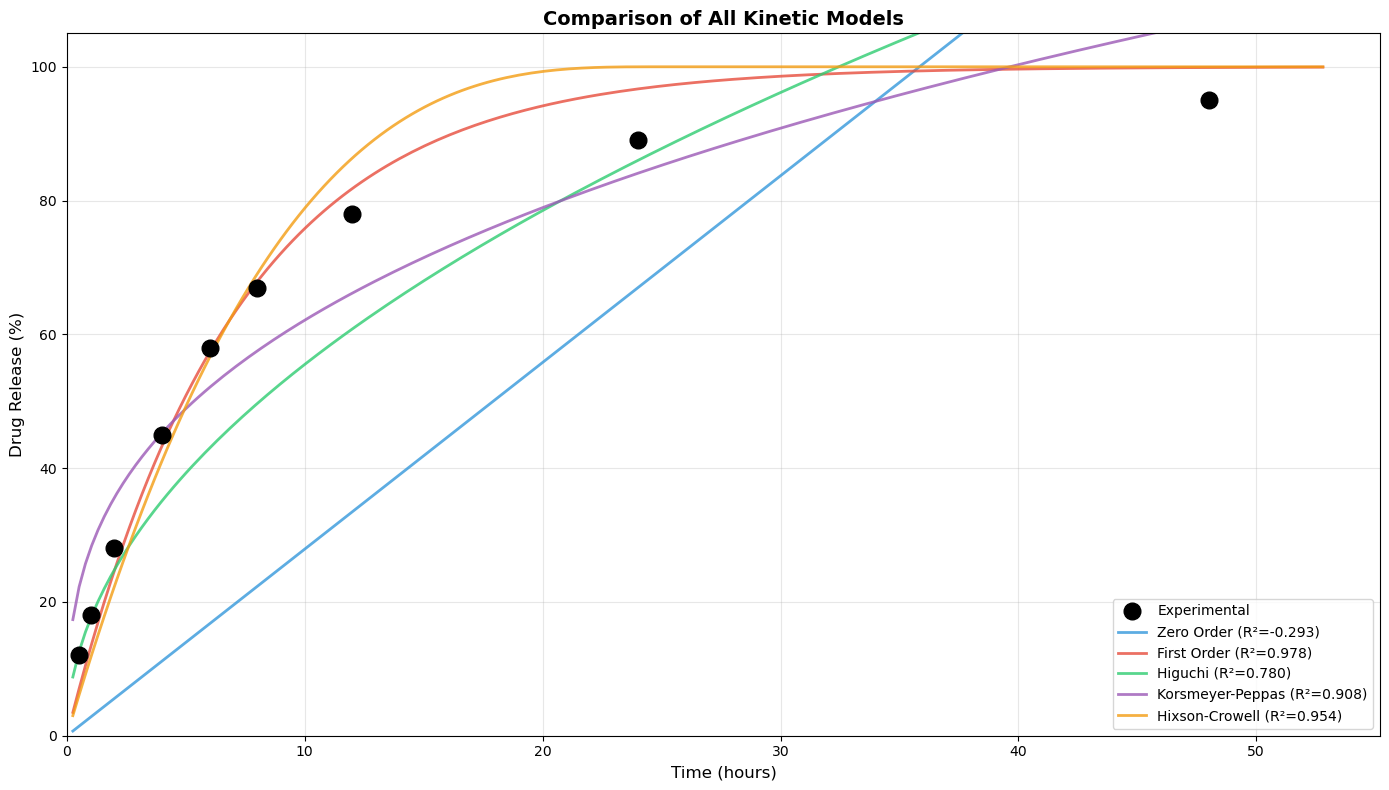


MODEL COMPARISON SUMMARY
Model                  R²         RMSE       Best? 
------------------------------------------------------------
Zero Order             -0.2928    32.78      
First Order            0.9784     4.23         ✓
Higuchi                0.7798     13.53      
Korsmeyer-Peppas       0.9079     8.75       
Hixson-Crowell         0.9537     6.20       


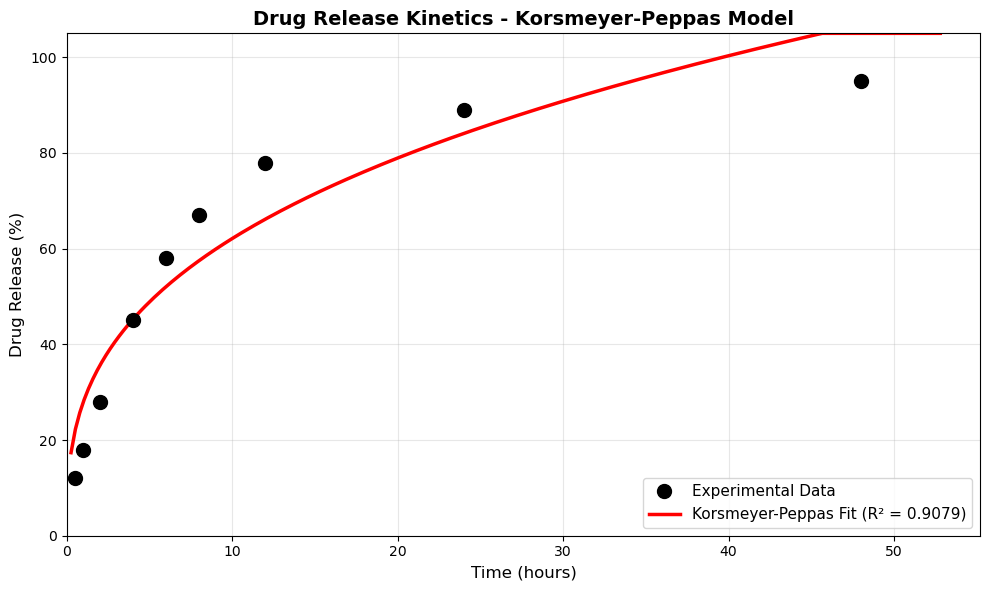

MODEL: Korsmeyer-Peppas

Fitted Parameters:
  k = 28.0288
  n = 0.3457

Goodness of Fit:
  R² = 0.9079
  RMSE = 8.75%

Release Mechanism Interpretation:
  n = 0.346 → Fickian diffusion (Case I)
DRUG RELEASE KINETICS ANALYZER

Data points: 9
Time range: 0.5 - 48.0 hours
Release range: 12.0 - 95.0%


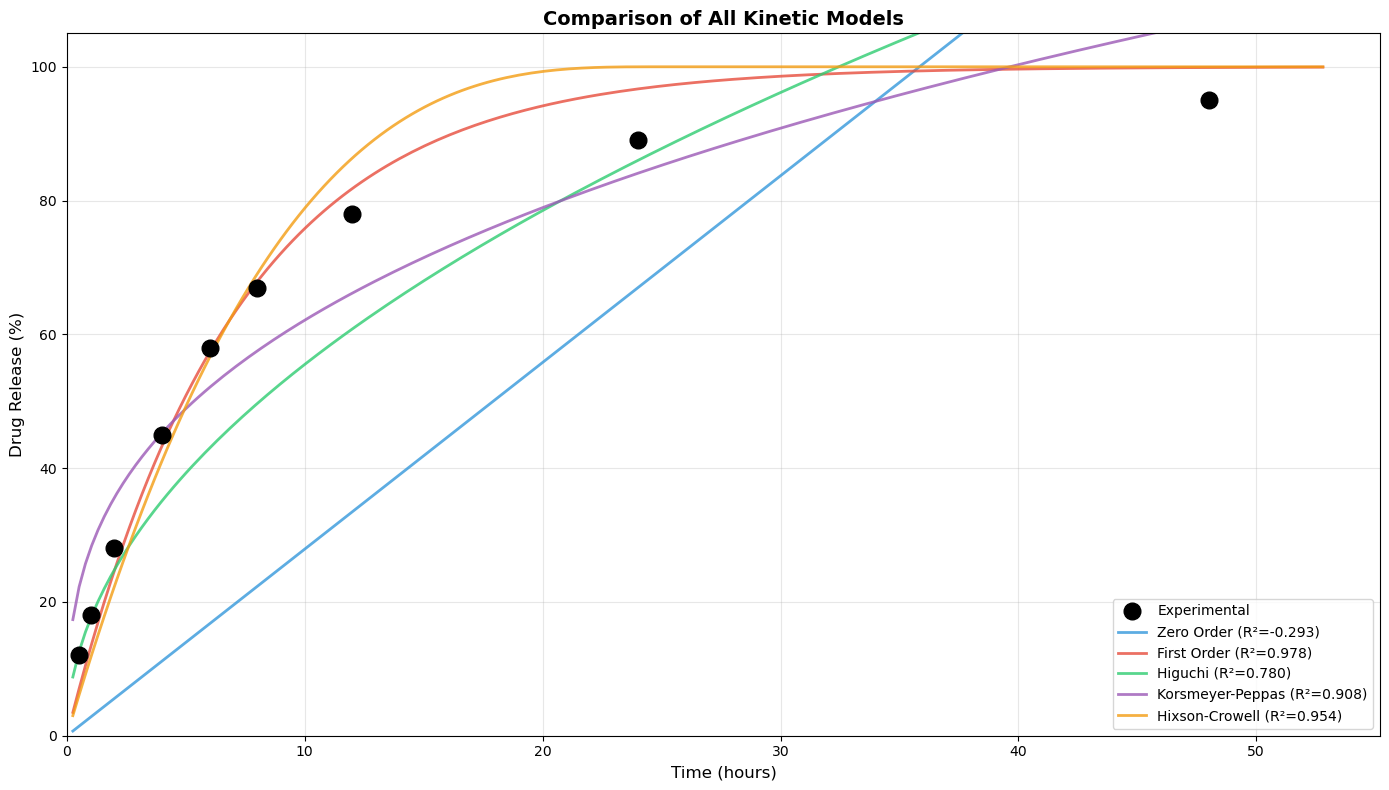


MODEL COMPARISON SUMMARY
Model                  R²         RMSE       Best? 
------------------------------------------------------------
Zero Order             -0.2928    32.78      
First Order            0.9784     4.23         ✓
Higuchi                0.7798     13.53      
Korsmeyer-Peppas       0.9079     8.75       
Hixson-Crowell         0.9537     6.20       

BEST MODEL: First Order


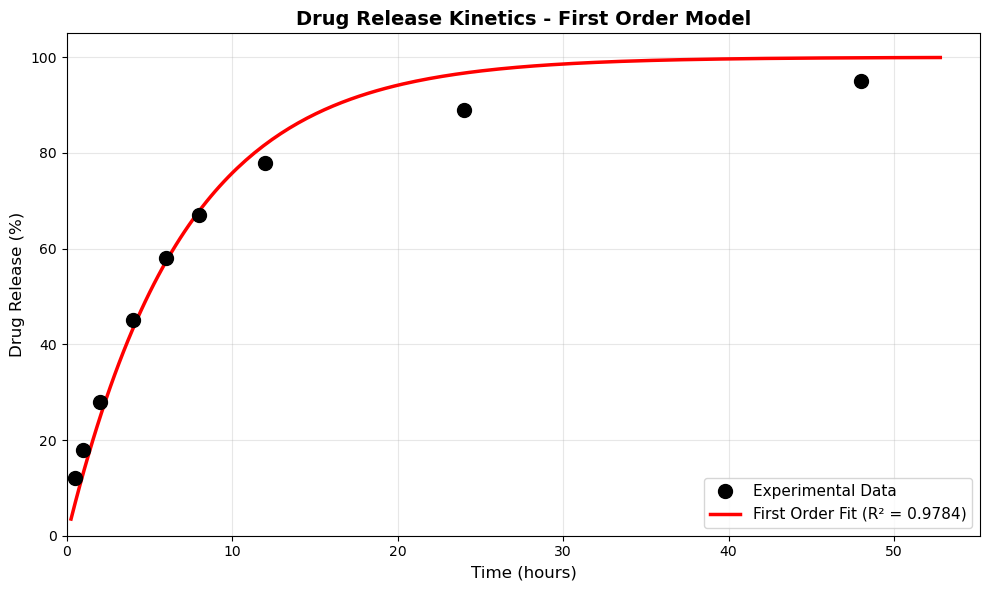

MODEL: First Order

Fitted Parameters:
  k = 0.1420

Goodness of Fit:
  R² = 0.9784
  RMSE = 4.23%
DRUG RELEASE KINETICS ANALYZER

Data points: 7
Time range: 0.5 - 24.0 hours
Release range: 8.0 - 96.0%


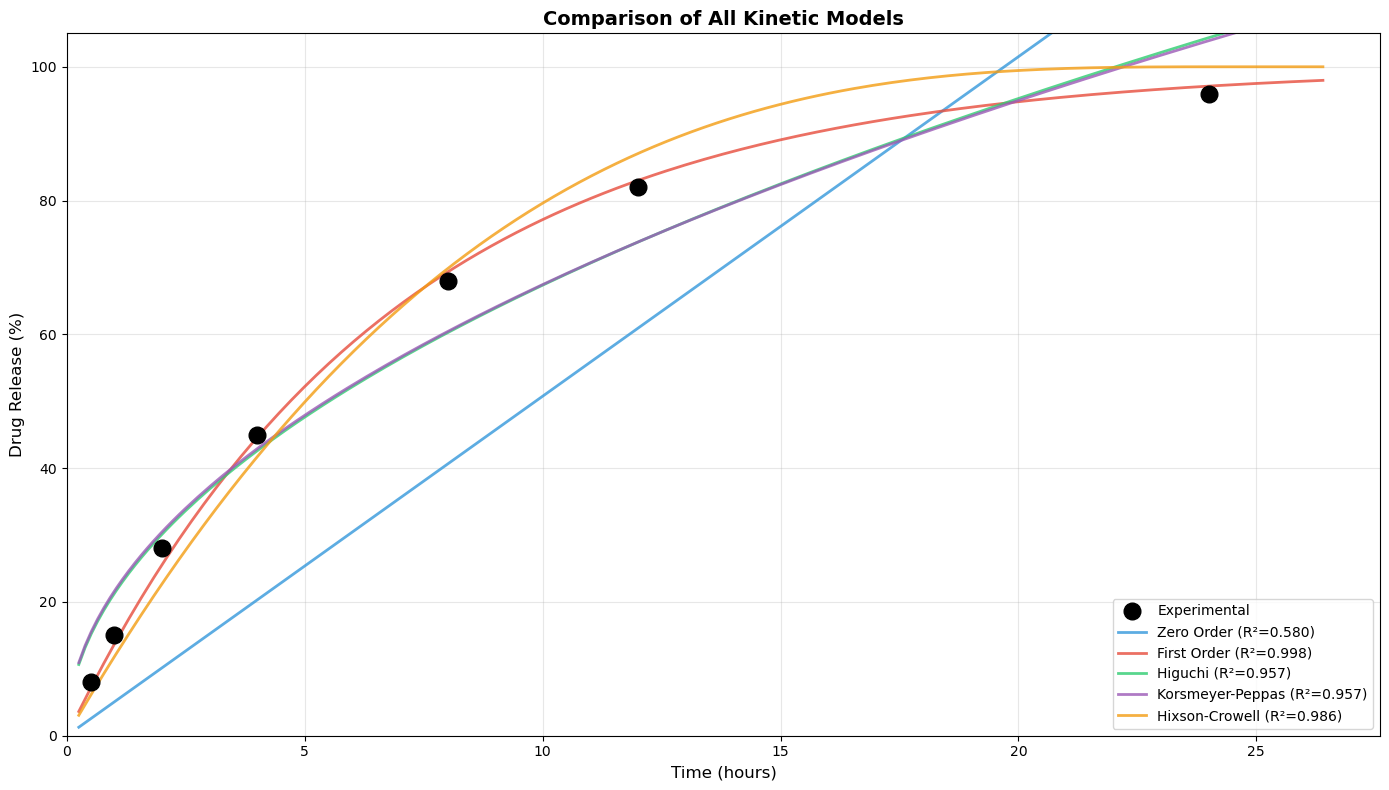


MODEL COMPARISON SUMMARY
Model                  R²         RMSE       Best? 
------------------------------------------------------------
Zero Order             0.5802     20.42      
First Order            0.9982     1.33         ✓
Higuchi                0.9573     6.52       
Korsmeyer-Peppas       0.9574     6.51       
Hixson-Crowell         0.9860     3.73       

BEST MODEL: First Order


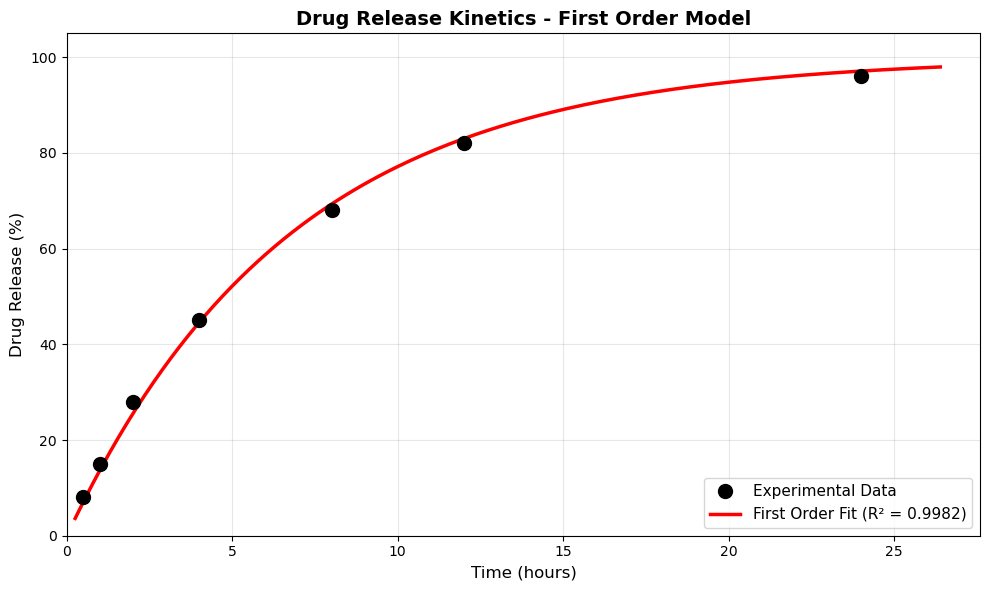

MODEL: First Order

Fitted Parameters:
  k = 0.1476

Goodness of Fit:
  R² = 0.9982
  RMSE = 1.33%


{'Zero Order': {'success': True,
  'params': {'k': np.float64(5.0754424091964)},
  'popt': array([5.07544241]),
  'r2': np.float64(0.5802205030718701),
  'rmse': np.float64(20.41941258999011),
  'predicted': array([  2.5377212 ,   5.07544241,  10.15088482,  20.30176964,
          40.60353927,  60.90530891, 121.81061782])},
 'First Order': {'success': True,
  'params': {'k': np.float64(0.1476468501294181)},
  'popt': array([0.14764685]),
  'r2': np.float64(0.9982153502970786),
  'rmse': np.float64(1.3314017551038366),
  'predicted': array([ 7.11643115, 13.72642638, 25.56870495, 44.59982318, 69.30820408,
         82.99669079, 97.10887476])},
 'Higuchi': {'success': True,
  'params': {'k': np.float64(21.299927001063484)},
  'popt': array([21.299927]),
  'r2': np.float64(0.9572657535948641),
  'rmse': np.float64(6.515093578568878),
  'predicted': array([ 15.06132282,  21.299927  ,  30.12264564,  42.599854  ,
          60.24529128,  73.78511153, 104.34790542])},
 'Korsmeyer-Peppas': {'succe

In [16]:
plot_all_models(TIME_DATA, RELEASE_DATA)
plot_single_model(TIME_DATA, RELEASE_DATA, 'Korsmeyer-Peppas')
interactive_analysis(TIME_DATA, RELEASE_DATA)
my_time = [0.5, 1, 2, 4, 8, 12, 24]
my_release = [8, 15, 28, 45, 68, 82, 96]
interactive_analysis(my_time, my_release)